In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, List, Tuple, Dict, Optional, Union
import numpy as np
import pandas as pd

import qubx
%qubxd dev

%load_ext autoreload
%autoreload 2

import qubx.pandaz.ta as pta
from qubx.data.readers import (
    CsvStorageDataReader, AsPandasFrame, AsOhlcvSeries, AsQuotes, RestoreTicksFromOHLC, AsTimestampedRecords,
)

from qubx.core.series import OHLCV, IndicatorOHLC, TimeSeries
from qubx.ta.indicators import (pewma, pewma_outliers_detector, psar, atr, swings)

r = CsvStorageDataReader('../tests/data/csv/')
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+15h', transform=AsOhlcvSeries('1Min', 'ms'))

ohlc_p = ohlc.pd()
qs = ohlc.close
ps = ohlc_p['close']

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# PEWMA

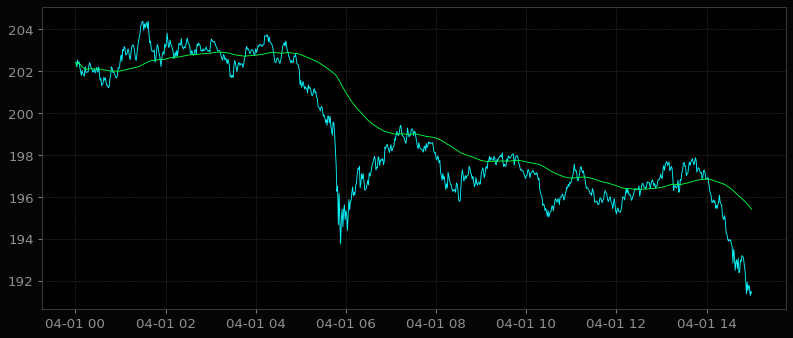

In [2]:
p0 = pta.pwma(ps, 0.99, 0.01, 30)
plt.plot(ps)
plt.plot(p0.Mean)

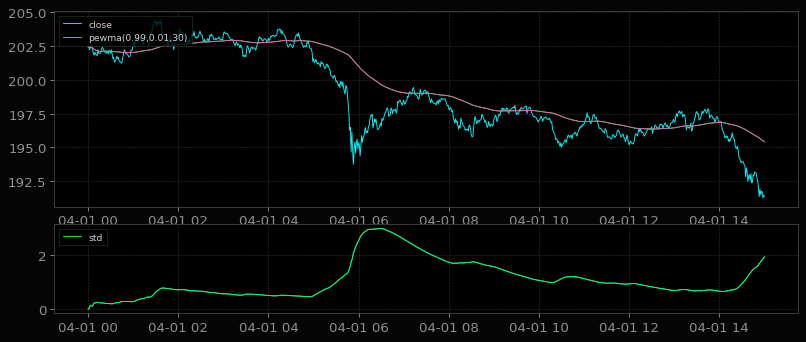

In [3]:
p1 = pewma(qs, 0.99, 0.01, 30)
sbp(31,1,r=2)
qs.plot()
p1.plot()
plt.plot(p0.Mean)
sbp(31,3)
plt.plot(p0.Std)
p1.std.plot()


In [9]:
# abs(np.mean(p1.pd() - p0.Mean)) < 1e-3
abs(np.mean(p1.std.pd() - p0.Std)) < 1e-3


True

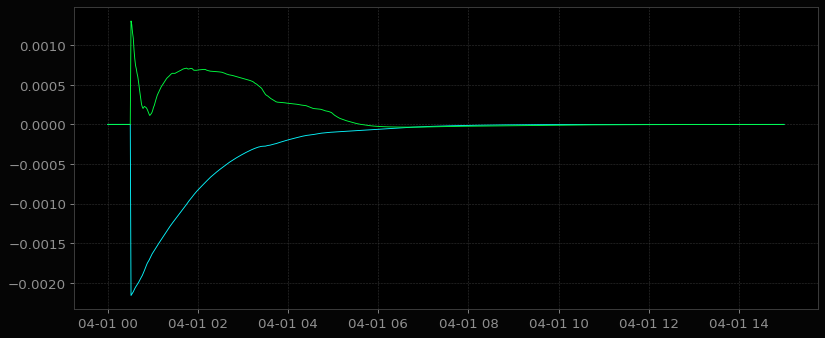

In [6]:
plt.plot(p1.pd() - p0.Mean)
plt.plot(p1.std.pd() - p0.Std)


## pwma_outliers_detector

In [7]:
t0 = pta.pwma_outliers_detector(ps, 0.99, 0.01)
t1 = pewma_outliers_detector(qs, 0.99, 0.01)


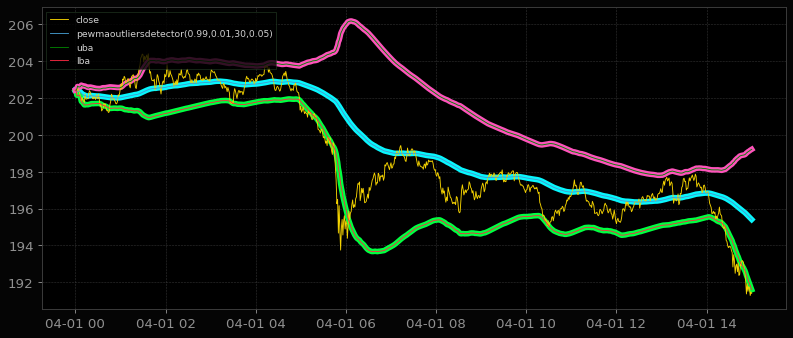

In [8]:
plt.plot(t0.m, lw=5)
plt.plot(t0.l, lw=5)
plt.plot(t0.u, lw=5)

qs.plot()
t1.plot()
t1.u.plot()
t1.l.plot()


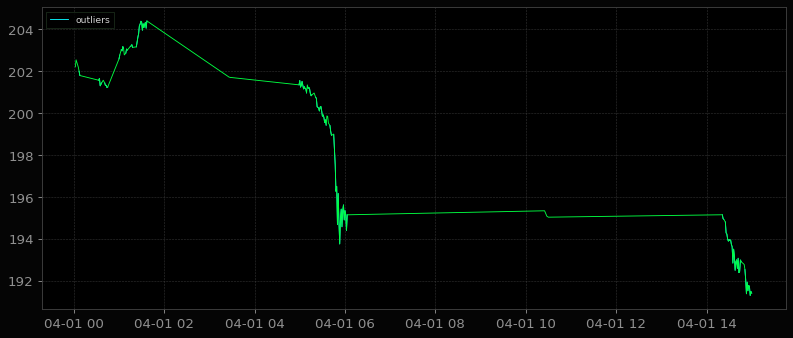

In [9]:
# plt.plot(t1.outliers)
t1.outliers.plot()
plt.plot(t0.outliers)


In [10]:
t1.outliers.pd().dropna()


2024-04-01 00:03:00    202.543
2024-04-01 00:07:00    201.998
2024-04-01 00:08:00    201.795
2024-04-01 00:33:00    201.569
2024-04-01 00:34:00    201.659
                        ...   
2024-04-01 14:56:00    191.770
2024-04-01 14:57:00    191.714
2024-04-01 14:58:00    191.285
2024-04-01 14:59:00    191.480
2024-04-01 15:00:00    191.396
Name: outliers, Length: 136, dtype: float64

In [11]:
t0.outliers


timestamp
2024-04-01 00:02:00    202.207
2024-04-01 00:03:00    202.543
2024-04-01 00:06:00    202.187
2024-04-01 00:07:00    201.998
2024-04-01 00:08:00    201.795
                        ...   
2024-04-01 14:56:00    191.770
2024-04-01 14:57:00    191.714
2024-04-01 14:58:00    191.285
2024-04-01 14:59:00    191.480
2024-04-01 15:00:00    191.396
Name: close, Length: 146, dtype: float64

# PSAR

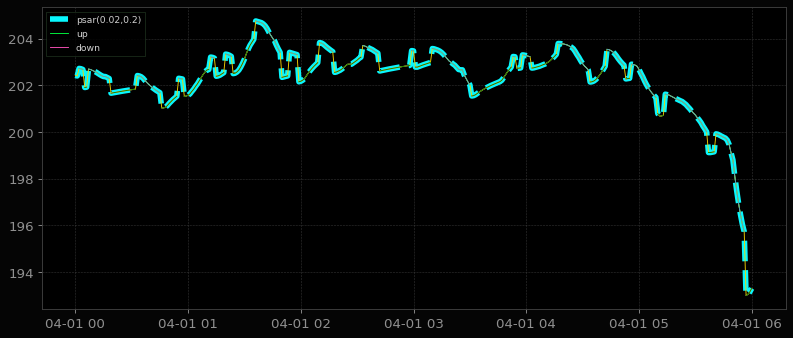

In [93]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+360Min", transform=AsOhlcvSeries("1Min", "ms"))
v = psar(ohlc)
e = pta.psar(ohlc.pd())
v.plot(ls="--", lw=5)
v.up.plot()
v.down.plot()

plt.plot(e.psar)
plt.plot(e.up)
plt.plot(e.down)

In [8]:
ohlc10 = OHLCV('test', '5Min')
v10 = psar(ohlc10)

for b in ohlc[::-1]:
    ohlc10.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)
e10 = pta.psar(ohlc10.pd())


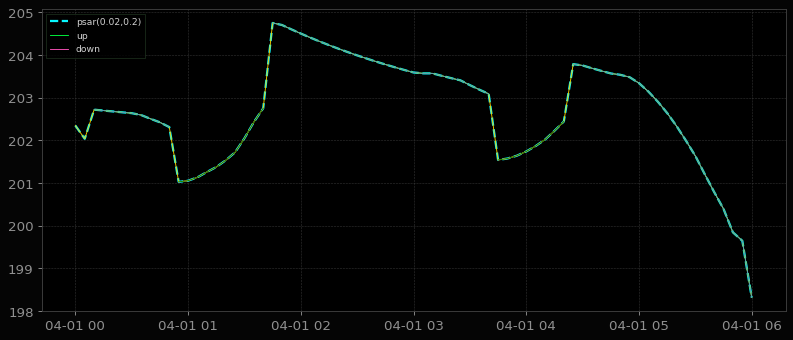

In [9]:
v10.plot(ls='--', lw=2)
v10.up.plot()
v10.down.plot()

plt.plot(e10.psar);
plt.plot(e10.up);
plt.plot(e10.down);


# ATR

In [61]:
# - test in py first
if 0:
    from qubx.ta.indicators import pewma, ema, sma, kama, tema, dema

    _smoothers = {f.__name__: f for f in [pewma, ema, sma, kama, tema, dema]}

    def smooth(series, smoother, *args, **kwargs):
        _sfn = _smoothers.get(smoother)
        if _sfn is None:
            raise ValueError(f"Smoother {smoother} not found!")
        return _sfn(series, *args, **kwargs)

    class Atr(IndicatorOHLC):
        def __init__(self, name, series, period, smoother, percentage):
            self.percentage = percentage
            self.tr = TimeSeries("tr", series.timeframe, series.max_series_length)
            self.ma = smooth(self.tr, smoother, period)
            super().__init__(name, series)

        def calculate(self, time, bar, new_item_started):

            if len(self.series) <= 1:
                return np.nan

            c1 = self.series[1].close
            h_l = abs(bar.high - bar.low)
            h_pc = abs(bar.high - c1)
            l_pc = abs(bar.low - c1)
            self.tr.update(time, max(h_l, h_pc, l_pc))
            return (100 * self.ma[0] / c1) if self.percentage else self.ma[0]

    def atr(series: OHLCV, period: int = 14, smoother="sma", percentage: bool = False):
        if not isinstance(series, OHLCV):
            raise ValueError("Series must be OHLCV !")
        return Atr.wrap(series, period, smoother, percentage)

In [4]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+5d", transform=AsOhlcvSeries("1Min", "ms"))
v = atr(ohlc, 14, "sma", percentage=False)
e = pta.atr(ohlc.pd(), 14, "sma", percentage=False)

In [1]:
(v.pd() - e).dropna().sum()

NameError: name 'v' is not defined

# Swings

In [143]:
if 1:
    from qubx.ta.indicators import psar


    class Swings(IndicatorOHLC):
        _min_l: float
        _min_t: int
        _max_h: float
        _max_t: int
        tops: TimeSeries
        bottoms: TimeSeries

        def __init__(self, name, series, trend_indicator, **indicator_args):
            self.ser = OHLCV("base", series.timeframe, series.max_series_length)
            self.trend = trend_indicator(self.ser, **indicator_args)
            self.tops = TimeSeries("tops", series.timeframe, series.max_series_length)
            self.bottoms = TimeSeries("bottoms", series.timeframe, series.max_series_length)
            self._min_l = +np.inf
            self._max_h = -np.inf
            self._max_t = 0
            self._min_t = 0
            super().__init__(name, series)

        def calculate(self, time, bar, new_item_started):
            self.ser.update_by_bar(time, bar.open, bar.high, bar.low, bar.close, bar.volume)
            _t = np.nan

            if len(self.trend.up) > 0:
                _u = self.trend.up[0]
                _d = self.trend.down[0]

                if not np.isnan(_u):
                    if self._max_t > 0:
                        self.tops.update(self._max_t, self._max_h)

                    if bar.low <= self._min_l:
                        self._min_l = bar.low
                        self._min_t = time

                    self._max_h = -np.inf
                    self._max_t = 0
                    _t = -1
                elif not np.isnan(_d):
                    if self._min_t > 0:
                        self.bottoms.update(self._min_t, self._min_l)

                    if bar.high >= self._max_h:
                        self._max_h = bar.high
                        self._max_t = time

                    self._min_l = +np.inf
                    self._max_t = time
                    self._min_t = 0
                    _t = +1

            return _t

        def get_current_trend_end(self) -> Tuple[pd.Timestamp|None, float|None]:
            if np.isfinite(self._min_l):
                return pd.Timestamp(self._min_t, 'ns'), self._min_l
            elif np.isfinite(self._max_h):
                return pd.Timestamp(self._max_t, 'ns'), self._max_h
            return (None, None)

        def pd(self) -> pd.DataFrame:
            _t, _d = self.get_current_trend_end()
            tps, bts = self.tops.pd(), self.bottoms.pd()
            if _t is not None:
                if bts.index[-1] < tps.index[-1]:
                    bts = srows(bts, pd.Series({_t: _d}))
                else:
                    tps = srows(tps, pd.Series({_t: _d}))

            eid = pd.Series(tps.index, tps.index)
            mx = scols(bts, tps, eid, names=["start_price", "end_price", "end"])
            dt = scols(mx["start_price"], mx["end_price"].shift(-1), mx["end"].shift(-1))  # .dropna()

            eid = pd.Series(bts.index, bts.index)
            mx = scols(tps, bts, eid, names=["start_price", "end_price", "end"])
            ut = scols(mx["start_price"], mx["end_price"].shift(-1), mx["end"].shift(-1))  # .dropna()
            return scols(ut, dt, keys=["DownTrends", "UpTrends"])


    def swings(series: OHLCV, trend_indicator, **indicator_args):
        if not isinstance(series, OHLCV):
            raise ValueError("Series must be OHLCV !")
        return Swings.wrap(series, trend_indicator, **indicator_args)

In [4]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+5h", transform=AsOhlcvSeries("10Min", "ms"))
v = swings(ohlc, psar, iaf=0.1, maxaf=1)
e = pta.swings(ohlc.pd(), pta.psar, iaf=0.1, maxaf=1)

_ps = psar(ohlc, iaf=0.1, maxaf=1)
# scols(_ps.up.pd(), _ps.down.pd())

In [5]:
v.pd()

DownTrends                                  UpTrends  \
                    start_price end_price                 end start_price   
2024-04-01 00:40:00         NaN       NaN                 NaT     201.030   
2024-04-01 01:30:00     204.755   202.150 2024-04-01 01:50:00         NaN   
2024-04-01 01:50:00         NaN       NaN                 NaT     202.150   
2024-04-01 02:50:00     203.700   201.543 2024-04-01 03:20:00         NaN   
2024-04-01 03:20:00         NaN       NaN                 NaT     201.543   
2024-04-01 04:10:00     203.790   202.140 2024-04-01 04:30:00         NaN   
2024-04-01 04:30:00         NaN       NaN                 NaT     202.140   
2024-04-01 04:40:00     203.540   201.000 2024-04-01 05:00:00         NaN   
2024-04-01 05:00:00         NaN       NaN                 NaT     201.000   

                                                   
                    end_price                 end  
2024-04-01 00:40:00   204.755 2024-04-01 01:30:00  
2024-04-01 01:30:00       NaN                 NaT  
2024-04-01 01:50:00   203.700 2024-04-01 02:50:00  
2024-04-01 02:50:00       NaN                 NaT  
2024-04-01 03:20:00   203.790 2024-04-01 04:10:00  
2024-04-01 04:10:00       NaN                 NaT  
2024-04-01 04:30:00   203.540 2024-04-01 04:40:00  
2024-04-01 04:40:00       NaN                 NaT  
2024-04-01 05:00:00       NaN                 NaT

In [ ]:
v.bottoms.pd()

In [121]:
v.tops.pd()

2024-04-01 01:30:00    204.755
2024-04-01 02:50:00    203.700
2024-04-01 04:10:00    203.790
2024-04-01 04:40:00    203.540
Name: tops, dtype: float64

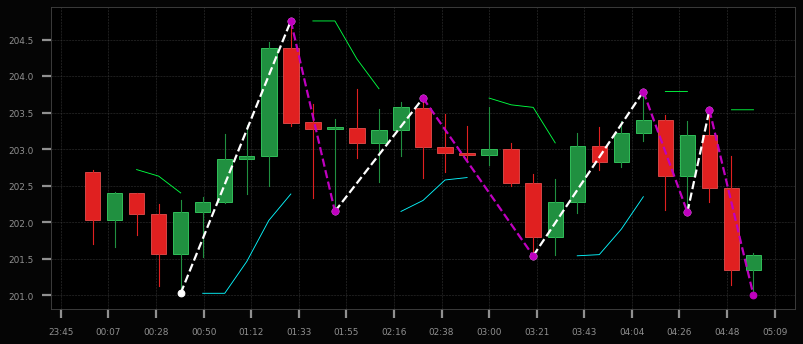

In [6]:
ohlc_plot(ohlc.pd())
plot_trends(e)
plt.plot(_ps.down.pd())
plt.plot(_ps.up.pd())

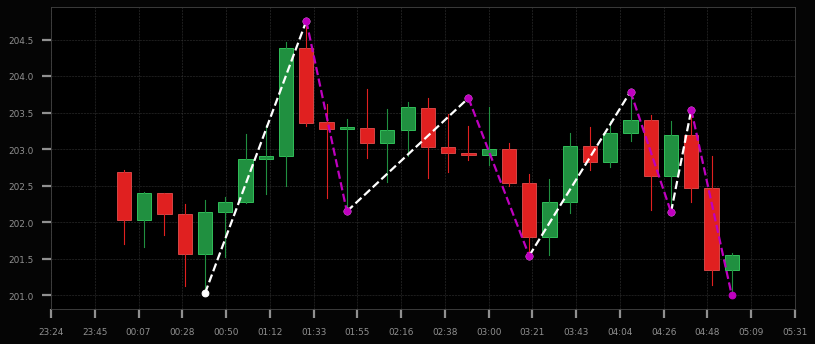

In [7]:
ohlc_plot(ohlc.pd())
plot_trends(v.pd())